# Exploratory Data Analysis on Financial News

This notebook performs all Exploratory Data Analysis (EDA) required for Task 1.  
The goals are:

- Understand dataset structure  
- Analyze headline text (length, keywords, patterns)  
- Explore publisher behavior  
- Examine publication time trends  
- Build foundations for sentiment analysis in Task 3  

This EDA will help uncover how news flow behaves and sets the stage for connecting sentiment to stock price movement later.

### Loading the libraries
Load libraries for:

- Data manipulation (`pandas`, `numpy`)  
- Visualization (`matplotlib`, `seaborn`)  
- Text analysis (CountVectorizer, LDA, WordCloud, TextBlob)  
- Warnings are suppressed for a cleaner notebook.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")



### Purpose
Load the dataset and inspect:

- First rows of data  
- Column types and missing values  

This ensures the dataset is ready for preprocessing.


In [17]:
df = pd.read_csv(r"C:\KAIM\week-1\financial-news-sentiment-analysis\data\raw_analyst_ratings.csv")
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

In [18]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


## Data Cleaning & Preprocessing

Prepare the dataset by:
- Standardizing column names  
- Converting `date` to datetime format  
- Removing duplicates and blank headlines  

This ensures clean and consistent data for text and time-series analysis.

In [ ]:
import pytz

# First, convert Python datetime to pandas Timestamp
df['date'] = df['date'].apply(pd.Timestamp)
df.columns = df.columns.str.lower().str.strip()
df.drop_duplicates(inplace=True)
# Then make everything UTC
df['date'] = df['date'].apply(lambda x: x.tz_convert('UTC') if x.tzinfo else x.tz_localize('UTC'))

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype              
---  ------           --------------    -----              
 0   Unnamed: 0       1407328 non-null  int64              
 1   headline         1407328 non-null  object             
 2   url              1407328 non-null  object             
 3   publisher        1407328 non-null  object             
 4   date             1407328 non-null  datetime64[ns, UTC]
 5   stock            1407328 non-null  object             
 6   headline_length  1407328 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 75.2+ MB


In [21]:
from dateutil import parser

df['date'] = df['date'].apply(lambda x: parser.parse(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   Unnamed: 0       1407328 non-null  int64 
 1   headline         1407328 non-null  object
 2   url              1407328 non-null  object
 3   publisher        1407328 non-null  object
 4   date             1407328 non-null  object
 5   stock            1407328 non-null  object
 6   headline_length  1407328 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 75.2+ MB


## Descriptive Statistics

### Headline Length

In [19]:
df["headline_length"] = df["headline"].str.len()
df["headline_length"].describe()


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

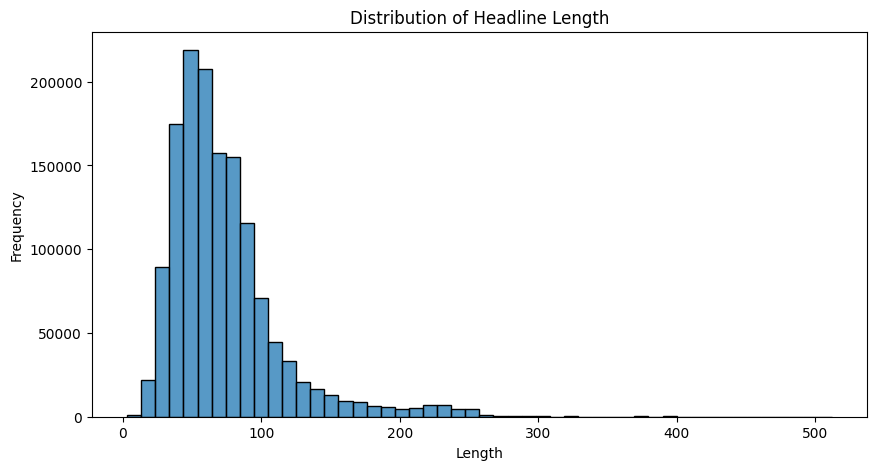

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(df["headline_length"], bins=50)
plt.title("Distribution of Headline Length")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

### Publisher Date Trends

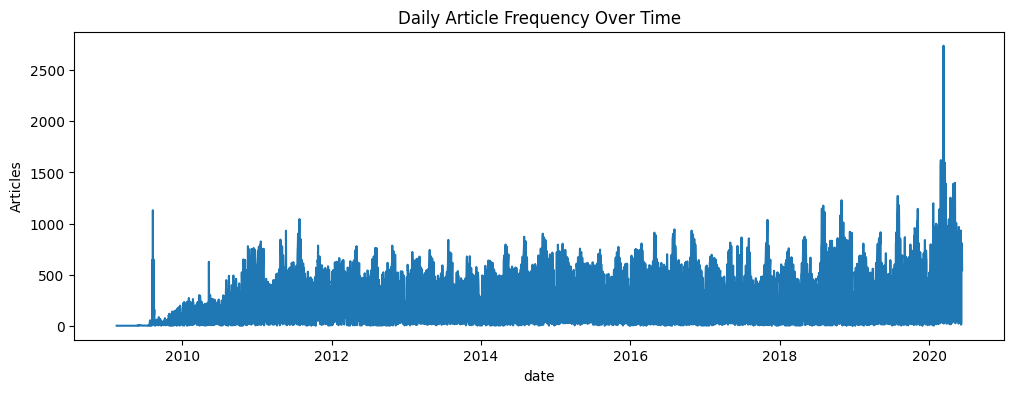

In [23]:
df.groupby(df["date"].dt.date).size().plot(figsize=(12,4))
plt.title("Daily Article Frequency Over Time")
plt.ylabel("Articles")
plt.show()


### Publisher Counts

In [24]:
publisher_counts = df["publisher"].value_counts()

publisher_counts.head(20)


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64

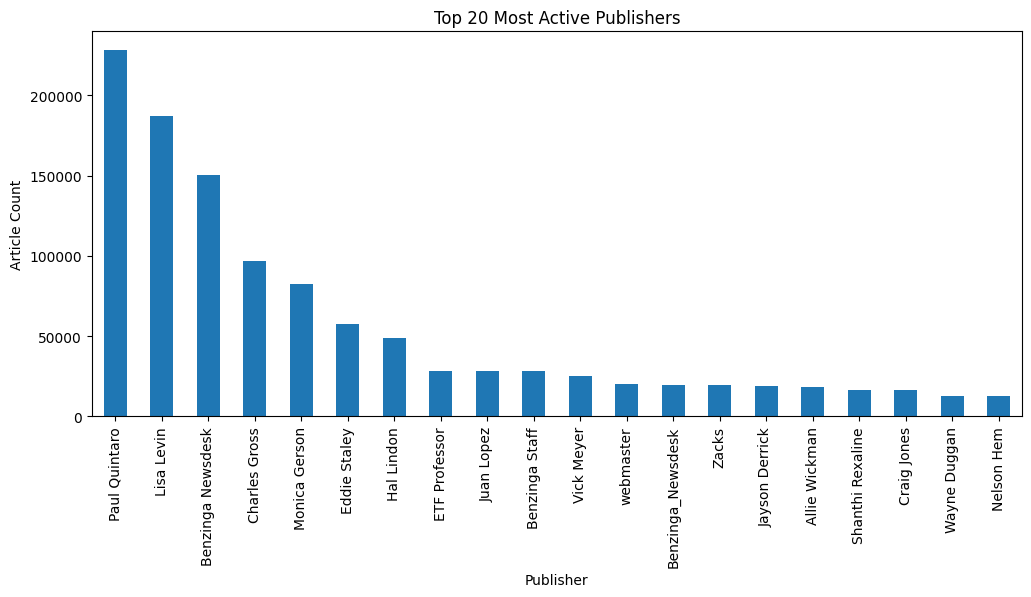

In [25]:
plt.figure(figsize=(12,5))
publisher_counts.head(20).plot(kind="bar")
plt.title("Top 20 Most Active Publishers")
plt.xlabel("Publisher")
plt.ylabel("Article Count")
plt.show()


### Purpose
Basic descriptive statistics help us understand:

- How long headlines typically are  
- Which publishers dominate the dataset  
- How news volume changes over time  

These insights show dataset biases, coverage patterns, and noise levels.


## Text Analysis - Keyword Extraction

In [26]:
cv = CountVectorizer(stop_words='english', max_features=50)
word_matrix = cv.fit_transform(df['headline'].astype(str))
keywords = cv.get_feature_names_out()

word_counts = np.array(word_matrix.sum(axis=0)).flatten()
keyword_df = pd.DataFrame({'keyword': keywords, 'count': word_counts})
keyword_df.sort_values('count', ascending=False).head(15)


,keyword,count
48,vs,162099
43,stocks,161776
15,est,140604
14,eps,128897
22,market,120558
41,shares,114313
34,reports,108710
46,update,91723
12,earnings,87399
35,sales,79645


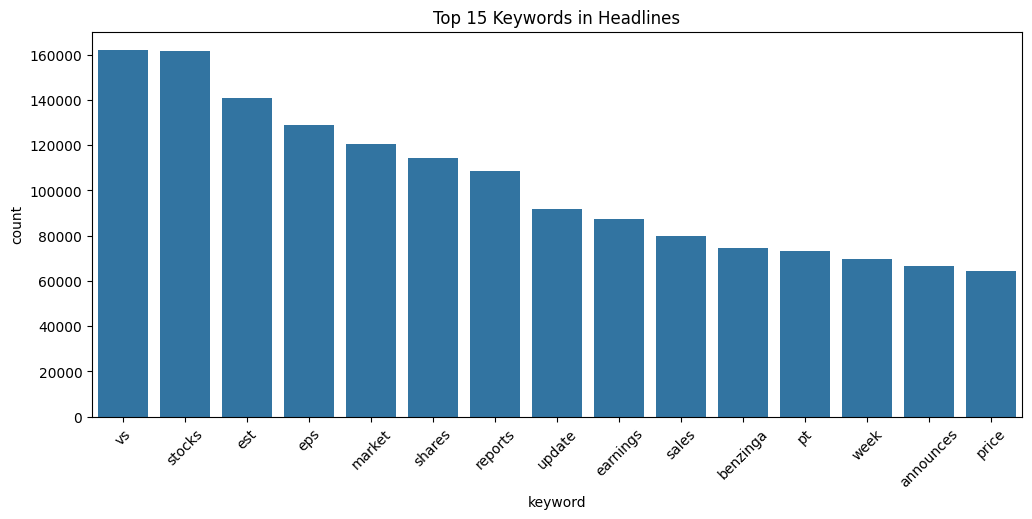

In [27]:
plt.figure(figsize=(12,5))
sns.barplot(data=keyword_df.sort_values('count', ascending=False).head(15),
            x='keyword', y='count')
plt.xticks(rotation=45)
plt.title("Top 15 Keywords in Headlines")
plt.show()


Keyword extraction identifies the **most common financial concepts** mentioned in the news.

Examples:
- “earnings”
- “shares”
- “upgrade”
- “price target”

This helps reveal:
- Which events drive financial news flow  
- What topics traders pay attention to  
- How market narrative shifts over time  

These keywords later help interpret why sentiment might influence stock returns.


## Text Analysis - WordCloud

A WordCloud visualizes the **most prominent words** in the corpus.

This helps understand:
- The general tone of the news  
- High-frequency events (earnings, guidance, merger, downgrade)  
- Major financial activities appearing across headlines  


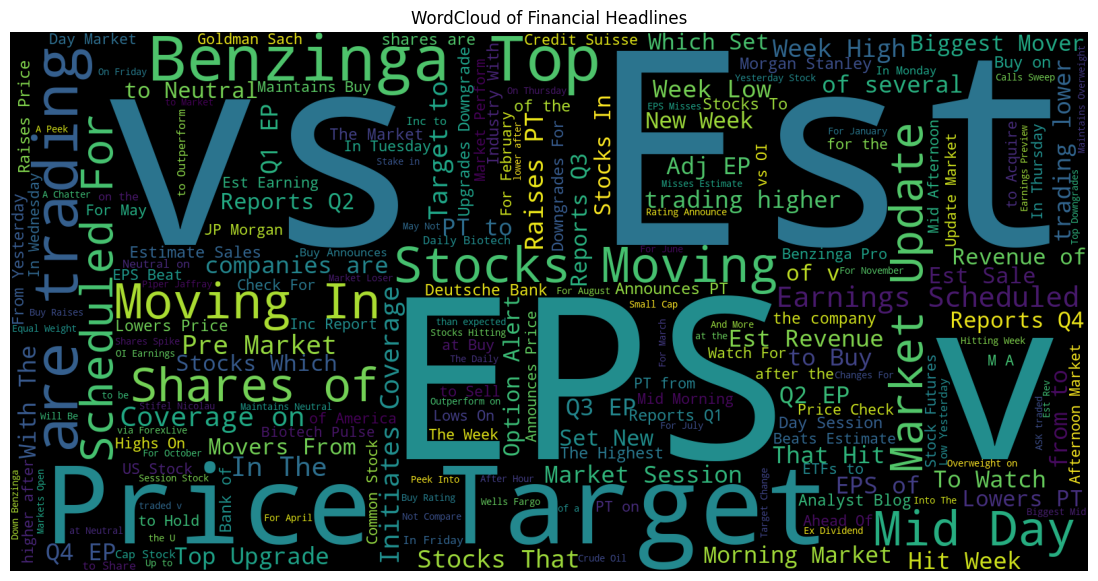

In [28]:
wc = WordCloud(width=1600, height=800, stopwords='english').generate(
    " ".join(df['headline'].astype(str))
)

plt.figure(figsize=(15,7))
plt.imshow(wc)
plt.axis('off')
plt.title("WordCloud of Financial Headlines")
plt.show()


## Text Analysis - Sentiment Scoring

In [29]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['headline'].apply(get_sentiment)
df['sentiment'].describe()


count    1.407328e+06
mean     4.905657e-02
std      1.830652e-01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: sentiment, dtype: float64

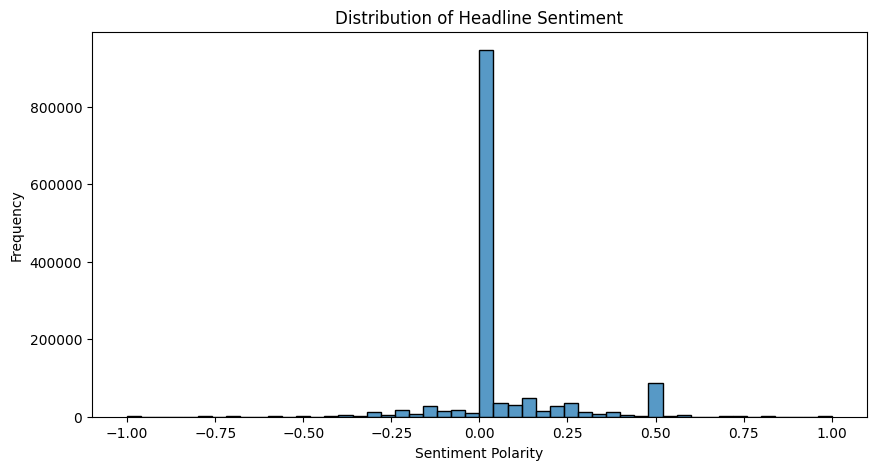

In [30]:
plt.figure(figsize=(10,5))
sns.histplot(df['sentiment'], bins=50)
plt.title("Distribution of Headline Sentiment")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()


Sentiment scoring quantifies the emotional tone of each headline.

TextBlob's polarity score:
- `> 0` → positive  
- `< 0` → negative  
- `0` → neutral  

Why this matters:
- Provides a measurable *sentiment signal*
- Enables aggregation by stock + date
- Essential for Task 3 correlation analysis with stock returns  


## Time-Series Text Insights

Publishing time patterns help detect:

- When markets receive the most news  
- Whether news clusters around market open/close  
- Weekday cycles (weekday higher, weekend lower)

This informs **timing alignment** for Task 3.


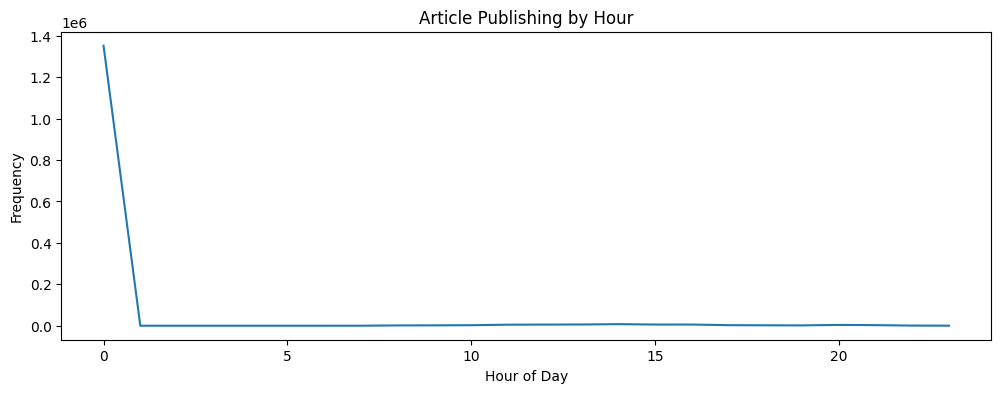

In [31]:
df['hour'] = df['date'].dt.hour
df['hour'].value_counts().sort_index().plot(kind='line', figsize=(12,4))
plt.title("Article Publishing by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency")
plt.show()


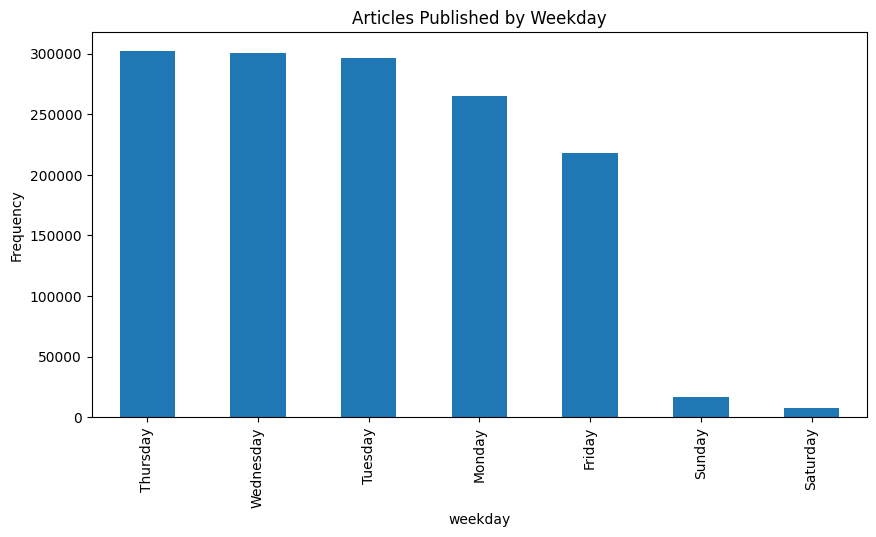

In [32]:
df['weekday'] = df['date'].dt.day_name()
df['weekday'].value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Articles Published by Weekday")
plt.ylabel("Frequency")
plt.show()


## Public Domain Extraction

If publishers are email addresses, this identifies the organization behind them, helpful for detecting institutional bias in news flow.


In [33]:
df['domain'] = df['publisher'].str.extract('@(.+)$')
df['domain'].value_counts().head(10)


domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64